# Religious Migration Analysis 1990-2020
#### Author: add later
#### Date: 11/21/2024
#### Data Source: Pew Research Center (https://www.pewresearch.org/dataset/dataset-religious-composition-of-the-worlds-migrants-1990-2020/)

This analysis explores global religious migration patterns from 1990-2020, examining how migration flows have influenced religious demographics across different geographical scales.

Dataset Structure:
- 26712 rows
- 9 columns
- Hierarchical data (Country -> Regional -> Global levels)
- Time period: 1990-2020 (5-year intervals)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [3]:
migration = pd.read_csv('data/Incoming_and_Outgoing_Migrant_Counts.csv', thousands=',')
migration.head(5)

,Direction,Year,Country,Religion,Count,Percent,Region,level,countrycode
0,Incoming,1990,Global Total,All,"152,970,000",100.0,Global,3,9999
1,Incoming,1990,Global Total,Buddhist,"4,590,000",3.0,Global,3,9999
2,Incoming,1990,Global Total,Christian,"72,710,000",47.5,Global,3,9999
3,Incoming,1990,Global Total,Hindu,"9,130,000",6.0,Global,3,9999
4,Incoming,1990,Global Total,Jew,"2,340,000",1.5,Global,3,9999


## Function definitions

In [5]:
def format_numbers(ax):
    """
    Format y-axis numbers to use comma separators instead of scientific notation.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis object to format
        
    Returns
    -------
    None
        Modifies the axis object in place

    Example
    -------
    >>> fig, ax = plt.subplots()
    >>> plot_data(ax)
    >>> format_numbers(ax)
    """
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

def explore_data_quality(df):
    """
    Perform initial data quality checks.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe to analyze
        
    Returns:
    --------
    dict
        Dictionary containing data quality metrics
    """
    quality_report = {
        'missing_values': df.isnull().sum(),
        'unique_values': {col: df[col].nunique() for col in df.columns},
        'data_types': df.dtypes
    }
    return quality_report

## Cleaning the data

In [7]:
explore_data_quality(migration)

{'missing_values': Direction      0
 Year           0
 Country        0
 Religion       0
 Count          0
 Percent        0
 Region         0
 level          0
 countrycode    0
 dtype: int64,
 'unique_values': {'Direction': 2,
  'Year': 7,
  'Country': 239,
  'Religion': 8,
  'Count': 834,
  'Percent': 955,
  'Region': 7,
  'level': 3,
  'countrycode': 239},
 'data_types': Direction       object
 Year             int64
 Country         object
 Religion        object
 Count           object
 Percent        float64
 Region          object
 level            int64
 countrycode      int64
 dtype: object}

In [8]:
#Changing the following column type to 'category' for memory optimization: Direction, Religion, Region, Level 
migration = migration.astype({
    'Direction': 'category',
    'Religion': 'category',
    'Region': 'category',
    'level': 'category',
})

#Standardized column names to lowercase
migration.columns = migration.columns.str.lower()

#Replacing values of '< 10,000' with 5,000 for numerical calculations. The number 5000 was chosen as a midpoint since we don't have the actual numbers
migration['count'] = migration['count'].replace('< 10,000', '5000')

#Remove commas from count column
migration['count'] = migration['count'].str.replace(',', '')

#Convert count from string to number
migration['count'] = pd.to_numeric(migration['count'])

## Global Migration

### Data Prep for Global Migration Analysis

In [11]:
global_level_df = migration[(migration['level'] == 3) & # filter for global level data
                          (migration['religion'] != 'All') & # remove 'All' value. 'All' rows total every religion
                          (migration['direction'] == 'Incoming')].copy() #Filter for only 'Incoming' to avoid doubling the actual number of migrants

global_level_df['religion'] = global_level_df['religion'].cat.remove_categories(['All']) # Removing 'All' from category so it doesn't show up in charts

order = global_level_df.groupby('religion', observed=True)['count'].mean().sort_values(ascending=False).index # Storing sort order in variable for barplot

#Pivot the dataframe with years as column, migration count as values and religion as index
global_growth_df = global_level_df.pivot_table(index='religion', columns='year', values='count')

global_growth_df['growthrate'] = (global_growth_df[2020] - global_growth_df[1990]) / global_growth_df[1990] * 100 #Add growth rate column

global_growth_df['abs_diff'] = global_growth_df[2020] - global_growth_df[1990] # Add an absolute difference column

# Pre/Post 2005 analysis due to noticeable spike after 2005

global_growth_df['post_2005'] = round((global_growth_df[2020] - global_growth_df[2005]) / global_growth_df[2005] * 100)
global_growth_df['pre_2005'] = round((global_growth_df[2005] - global_growth_df[1990]) / global_growth_df[1990] * 100)
global_growth_df.reset_index(inplace=True)
global_period_df = pd.melt(global_growth_df, 
                           id_vars=['religion'], 
                           value_vars=['pre_2005', 'post_2005'], 
                           var_name='period', 
                           value_name='growth rate')

#### Global migration patterns show steady growth from 1990 to 2020, with a notable acceleration after 2005. During this period, both the volume and composition of religious migration underwent significant changes...

**Key Findings**:
- Global migration increased 83.4% from 1990 to 2020.
- Christians and Muslims consistently represent the largest migration groups.
- Despite smaller total numbers, Buddhist migration showed the highest growth rate of 137%.
- Muslims had the largest migration growth rate post-2005.
- Buddhists were the only group to see a decline in migration growth post-2005.
- Jewish migration remains generally low, indicating some level of stability.

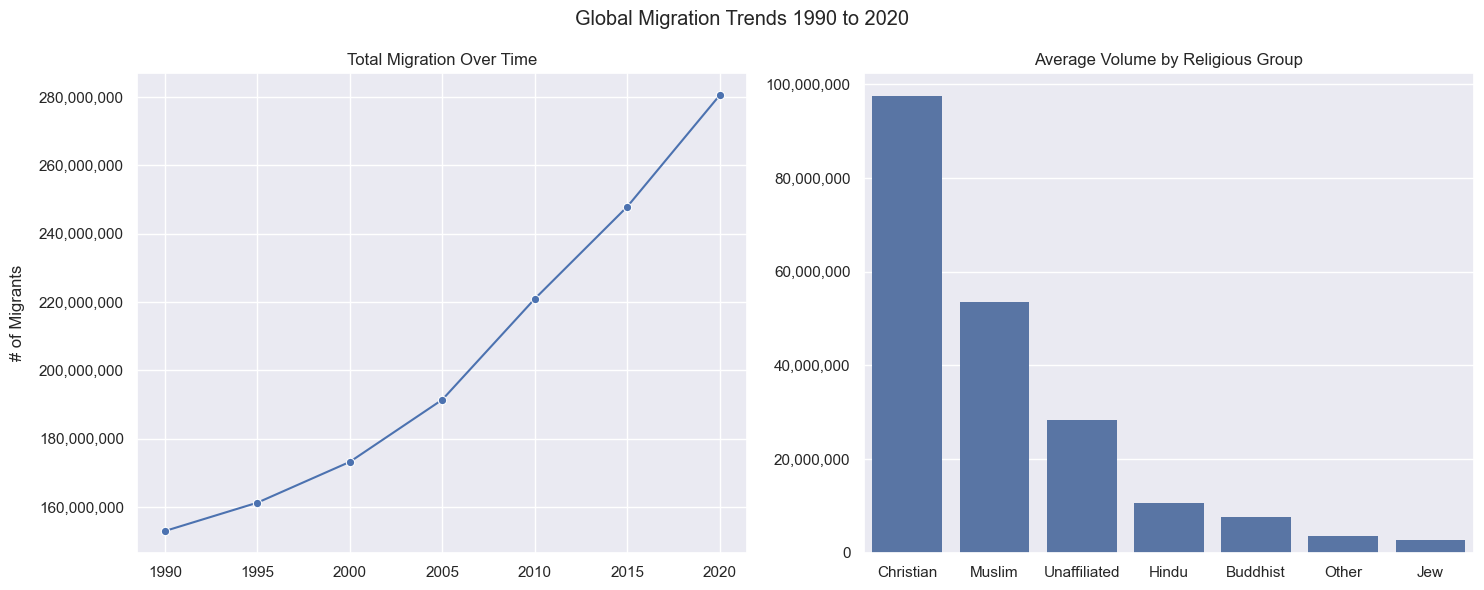

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(data=global_level_df, 
             x='year', y='count', 
             errorbar=None, marker='o', 
             estimator=sum, ax=ax1)
format_numbers(ax1)
ax1.set_ylabel('# of Migrants', labelpad=10)
ax1.set_xlabel('')
ax1.set_title('Total Migration Over Time')

sns.barplot(data = global_level_df, 
            x='religion', y='count', 
            errorbar=None, order=order, 
            linewidth=0, ax=ax2)
format_numbers(ax2)
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.set_title('Average Volume by Religious Group')

plt.suptitle('Global Migration Trends 1990 to 2020')
plt.tight_layout()

### Global Growth Rates
How have growth rates changed?

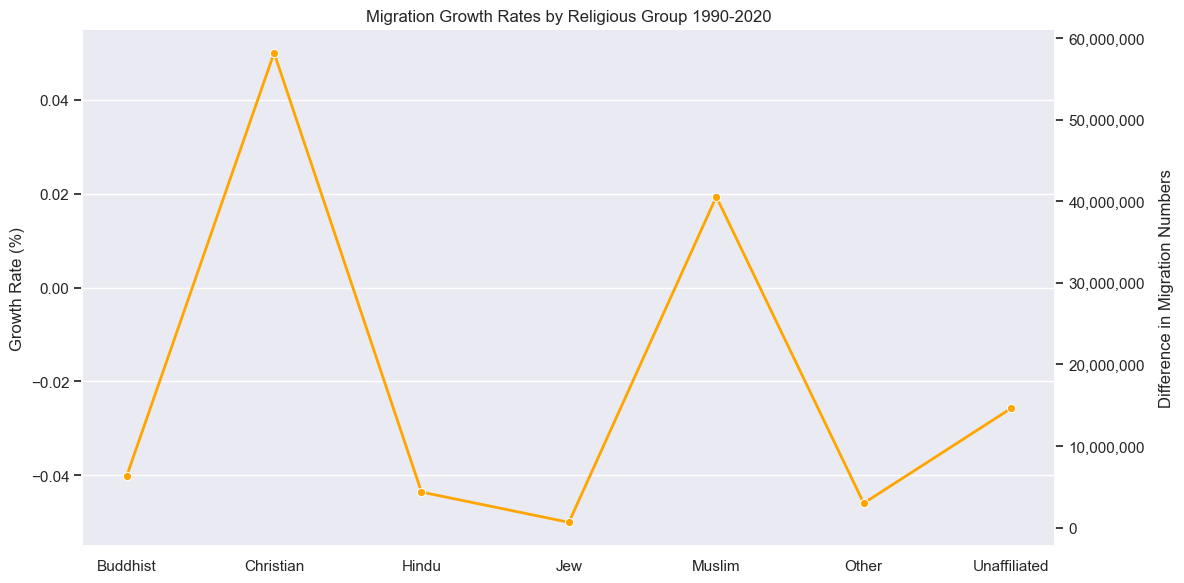

In [15]:
global_growth_df['post_2005'] = round((global_growth_df[2020] - global_growth_df[2005]) / global_growth_df[2005] * 100)
global_growth_df['pre_2005'] = round((global_growth_df[2005] - global_growth_df[1990]) / global_growth_df[1990] * 100)
global_growth_df.reset_index(inplace=True)
global_period_df = pd.melt(global_growth_df, 
                           id_vars=['religion'], 
                           value_vars=['pre_2005', 'post_2005'], 
                           var_name='period', 
                           value_name='growth rate')

fig, ax1 = plt.subplots(figsize=(12, 6))
sns.barplot(data=global_growth_df, 
            x='religion', y='growthrate',
           order=global_growth_df.sort_values('growthrate', ascending=False).index,
           ax=ax1)

ax1.set_xlabel('')
ax1.set_ylabel('Growth Rate (%)')
ax1.bar_label(ax1.containers[0], label_type='center', color='white', fmt=lambda x: f'{x:.0f}%')

ax2 = ax1.twinx()
sns.lineplot(data=global_growth_df,
             x='religion', y='abs_diff',
             ax=ax2, color='orange',
             linewidth=2, marker='o')

format_numbers(ax2)
ax2.set_ylabel('Difference in Migration Numbers', labelpad=10)
ax2.grid(alpha=0)


plt.title('Migration Growth Rates by Religious Group 1990-2020')
plt.tight_layout()

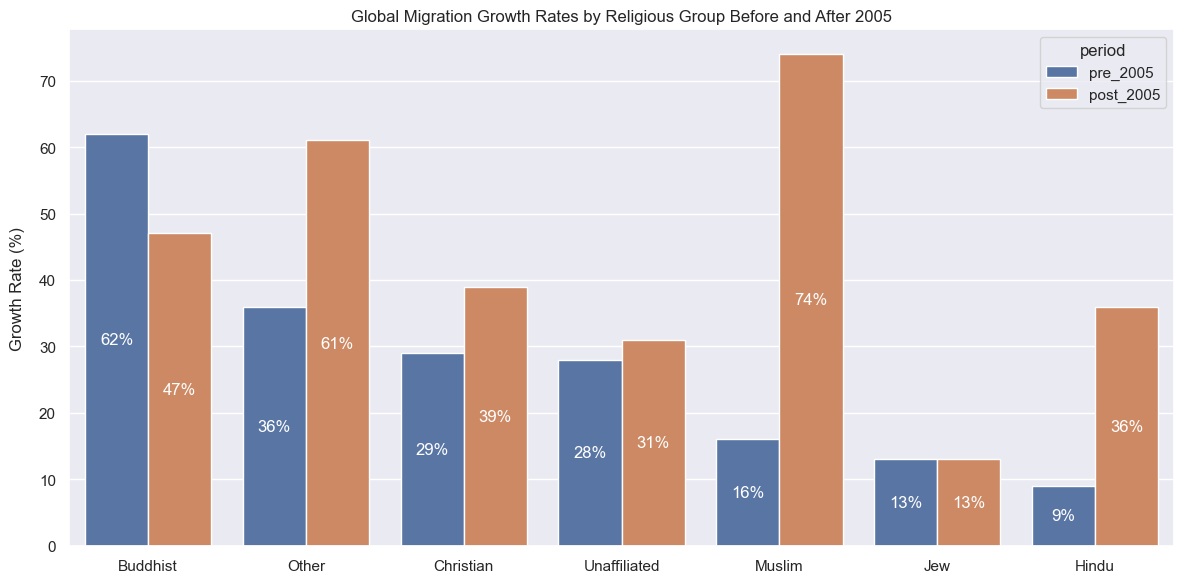

In [16]:
plt.figure(figsize=(12, 6))

order = global_period_df[global_period_df['period'] == 'pre_2005'].sort_values('growth rate', ascending=False)['religion']

ax = sns.barplot(global_period_df, 
                 x='religion', y='growth rate', 
                 hue='period', order=order)
for container in ax.containers:
    ax.bar_label(container, label_type='center', color='white', fmt=lambda x: f'{x:.0f}%')

plt.xlabel('')
plt.ylabel('Growth Rate (%)', labelpad=10)
plt.title('Global Migration Growth Rates by Religious Group Before and After 2005')

plt.tight_layout()

#### These global patterns, however, mask significant regional variations in both the volume and religious composition of migration flows...

# Regional Breakdown

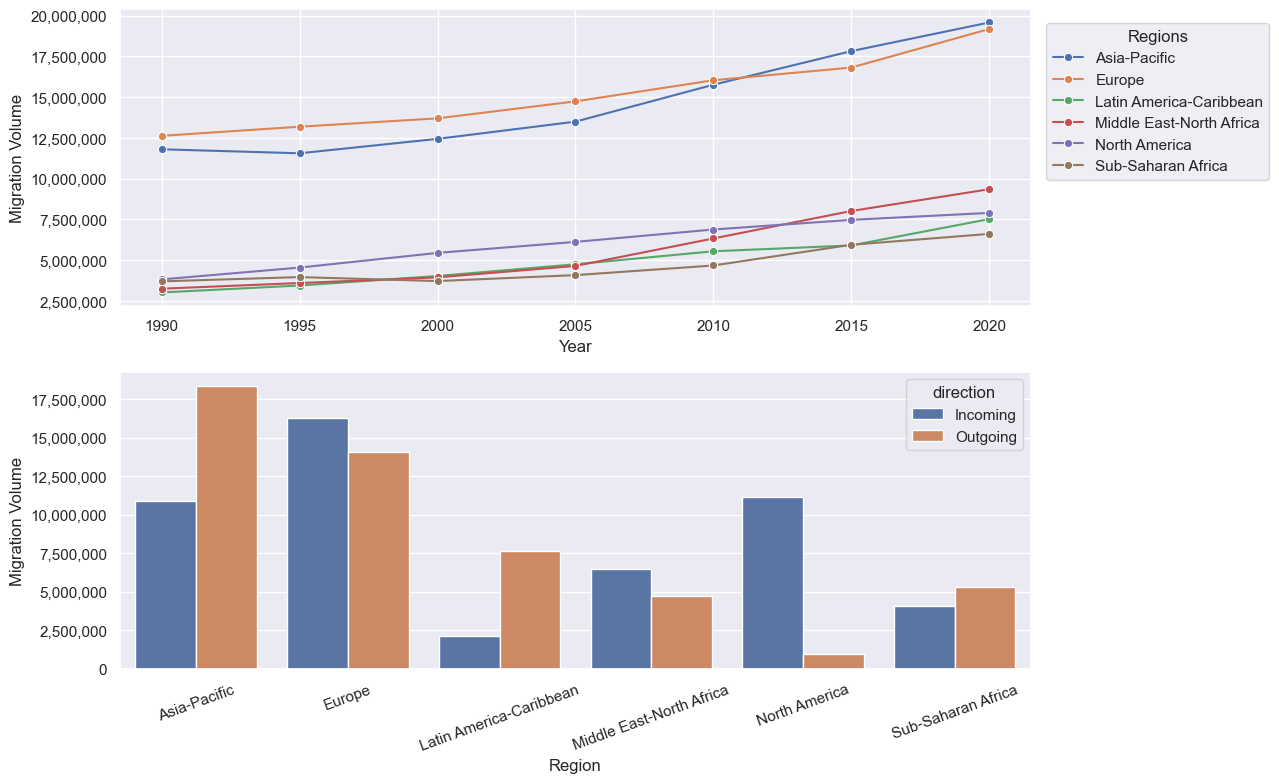

In [19]:
region_level_df = migration[migration['level'] == 2].copy()
region_level_df['region'] = region_level_df['region'].cat.remove_categories(['Global'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8))  # Make figure wider
plt.subplots_adjust(right=0.85)  # Leave room for legend

sns.lineplot(data=region_level_df, x='year', y='count', hue='region', errorbar=None, marker='o', ax=ax1)
ax1.set_xlabel('Year')
ax1.set_ylabel('Migration Volume')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.legend(title="Regions",loc='center', bbox_to_anchor=(1.14, 0.69))

sns.barplot(data=region_level_df, x='region', y='count', errorbar=None, hue='direction', ax=ax2)

ax2.set_xlabel('Region')
ax2.set_ylabel('Migration Volume')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=20)

plt.tight_layout()

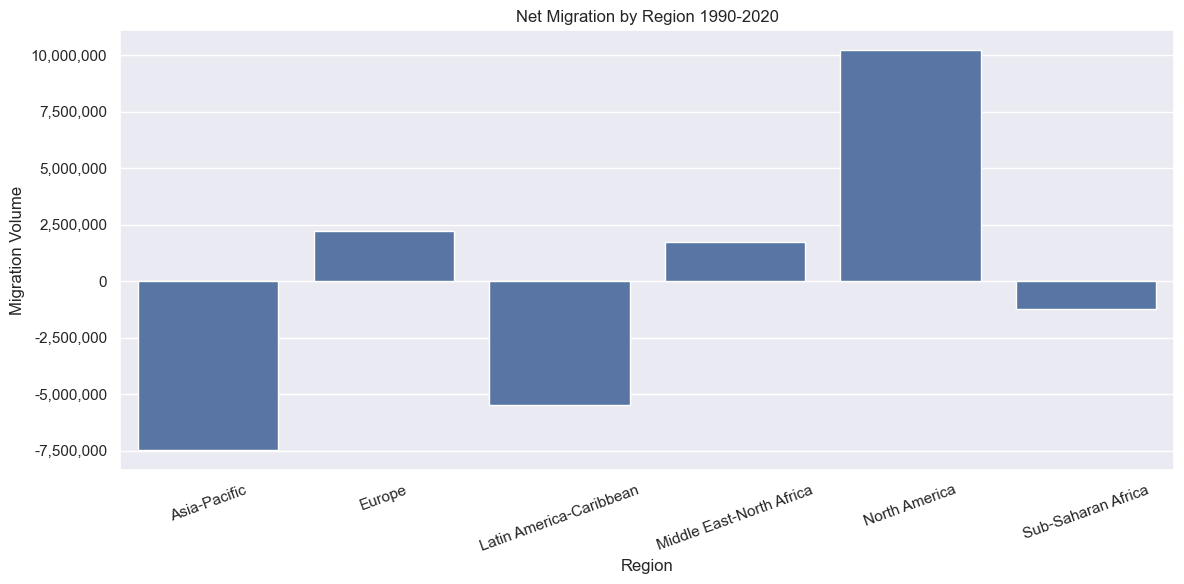

In [20]:
#Analyzing net migration for each region (consider showing over time)
#pivoting region_level_df to focus on incoming vs outgoing by region
pivoted_region_level = region_level_df.pivot_table(values='count', columns='direction', index='region').astype('int')
net_diff = pivoted_region_level['Incoming'] - pivoted_region_level['Outgoing']

plt.figure(figsize=(12, 6))
ax = sns.barplot(net_diff)
format_numbers(ax)

plt.title('Net Migration by Region 1990-2020')
plt.ylabel('Migration Volume')
plt.xlabel('Region')
plt.xticks(rotation=20)
plt.tight_layout()

In [21]:
pivoted_region_year_df = region_level_df.pivot_table(values='count', columns='direction', index=['region', 'year'])
pivoted_region_year_df['net_migration'] = pivoted_region_year_df['Incoming'] - pivoted_region_year_df['Outgoing']
net_migration_df = pivoted_region_year_df.reset_index(['region', 'year'])
net_migration_df.head()

direction,region,year,Incoming,Outgoing,net_migration
0,Asia-Pacific,1990,9991250.0,13612500.0,-3621250.0
1,Asia-Pacific,1995,9231250.0,13883750.0,-4652500.0
2,Asia-Pacific,2000,9587500.0,15295000.0,-5707500.0
3,Asia-Pacific,2005,10021250.0,16972500.0,-6951250.0
4,Asia-Pacific,2010,11155000.0,20362500.0,-9207500.0


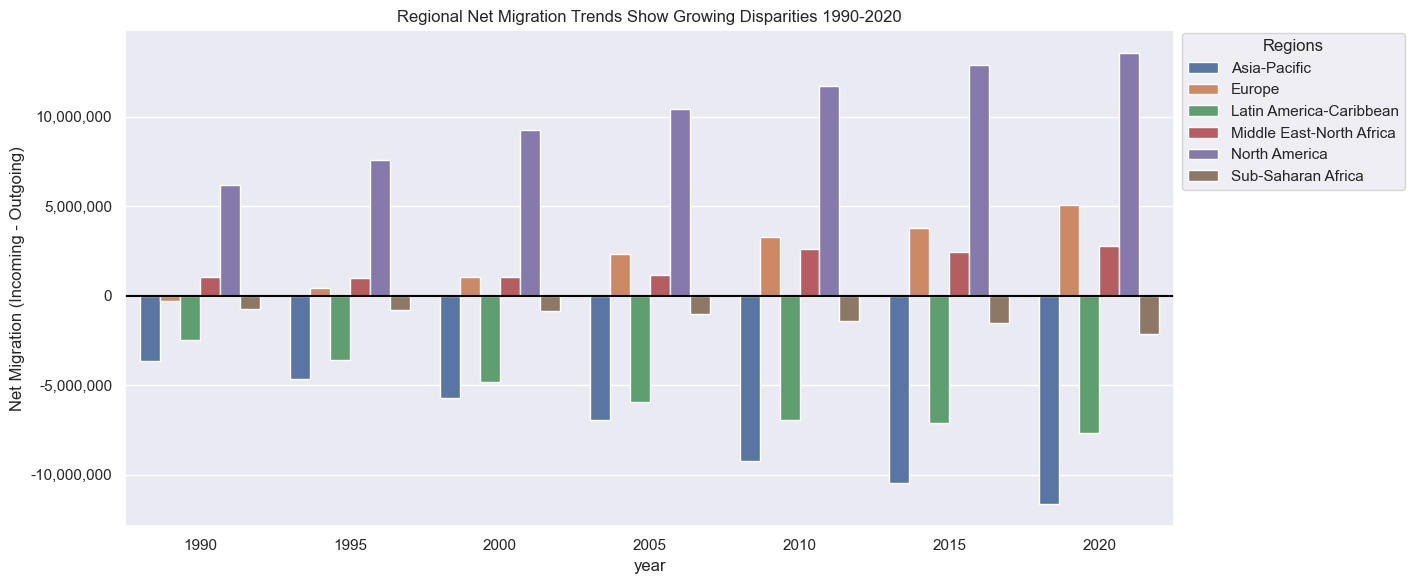

In [22]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(net_migration_df, 
                 x='year', 
                 y='net_migration', 
                 hue='region')
format_numbers(ax)
plt.ylabel('Net Migration (Incoming - Outgoing)')
plt.title('Regional Net Migration Trends Show Growing Disparities 1990-2020')

plt.axhline(y=0, color='black', linestyle='-')

plt.tight_layout()
plt.legend(title="Regions", bbox_to_anchor=(1, 1.01));

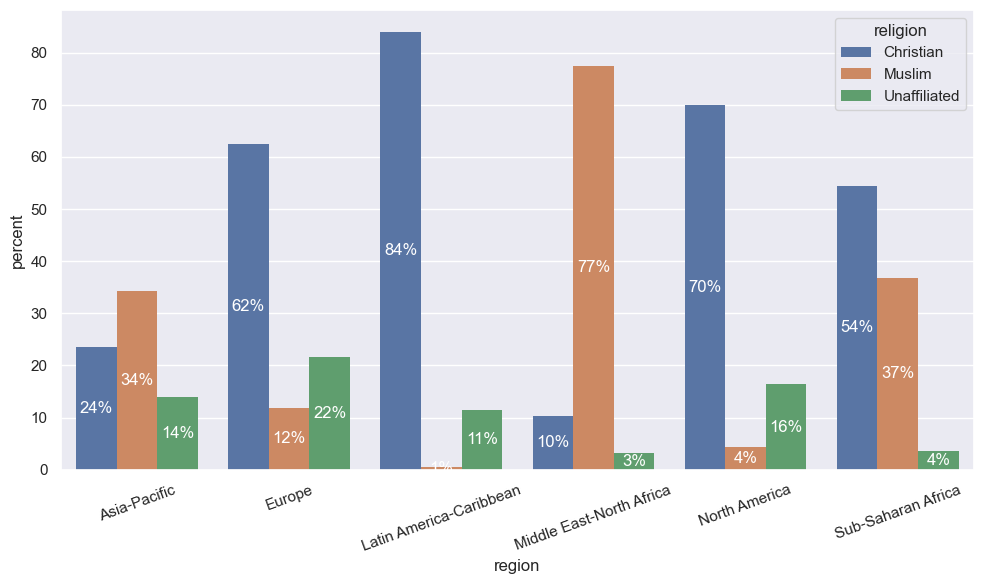

In [23]:
desired_religions = ['Christian', 'Muslim', 'Unaffiliated']
pivoted_region_religion_df = (region_level_df[region_level_df['religion'].isin(desired_religions)]
                            .pivot_table(index=['region', 'religion'], 
                                       values='percent')
                            .reset_index())

pivoted_region_religion_df['religion'] = pivoted_region_religion_df['religion'].cat.remove_categories(['All', 'Buddhist', 'Hindu', 'Jew', 'Other'])

# ---------------plots below
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=pivoted_region_religion_df, 
                 x='region', 
                 y='percent', 
                 hue='religion',
                linewidth=0)

for container in ax.containers:
    ax.bar_label(container, label_type='center', color='white', fmt=lambda x: f'{x:.0f}%')
    
format_numbers(ax)
plt.xticks(rotation=20)
plt.tight_layout()

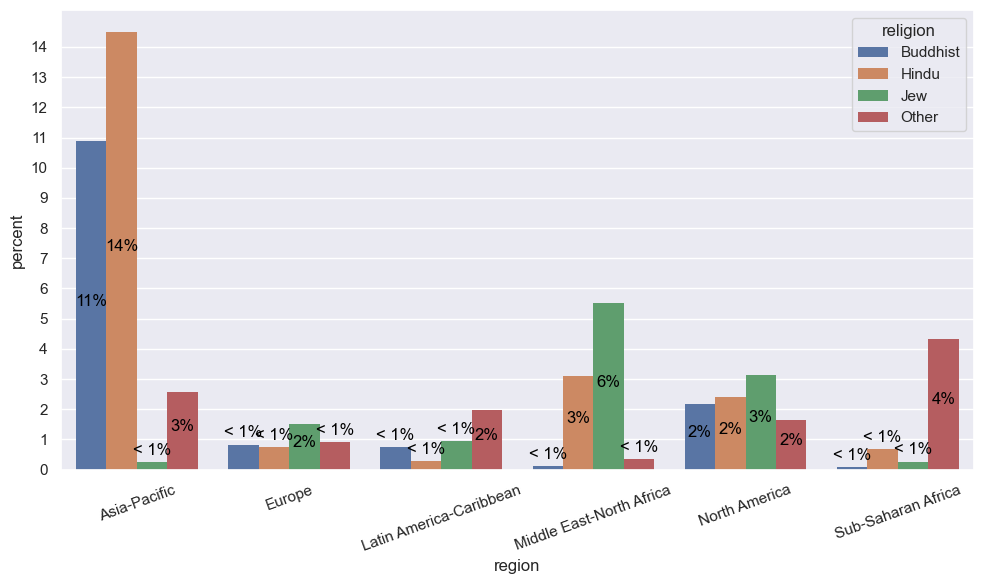

In [24]:
desired_religions = ['Buddhist', 'Hindu', 'Jew', 'Other']
pivoted_region_religion_df = (region_level_df[
    (region_level_df['religion'].isin(desired_religions))
    ]
    .pivot_table(index=['region', 'religion'], 
                values='percent')
    .reset_index())
pivoted_region_religion_df['religion'] = pivoted_region_religion_df['religion'].cat.remove_categories(['All', 'Christian', 'Muslim', 'Unaffiliated'])
# ---------------plots below
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=pivoted_region_religion_df, 
                 x='region', 
                 y='percent', 
                 hue='religion',
                linewidth=0)


for container in ax.containers:
    # Handle values >= 1%
    ax.bar_label(container, label_type='center', color='black',
                fmt=lambda x: f'{x:.0f}%' if x >= 1 else '', 
                padding=3)
    # Handle values < 1%
    ax.bar_label(container, label_type='edge', color='black',
                fmt=lambda x: '< 1%' if x < 1 else '', 
                padding=3)
    
format_numbers(ax)
plt.xticks(rotation=20)
plt.yticks(range(0, 15, 1))  # ticks every 5%
plt.tight_layout()